In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import perf_counter
import warnings

warnings.filterwarnings("ignore")

## Implementation

In [2]:
def generate_supreme_solution(circle_radius, n_trials, rectangles):
    solution = []
    score = 0
    for i in range(len(rectangles)):
        for _ in range(n_trials):
            x = np.random.uniform(-circle_radius, circle_radius)
            y = np.random.uniform(-circle_radius, circle_radius)
            # left bottom corner in circle
            if np.sqrt(x**2 + y**2) > circle_radius:
                continue
            rectangle = rectangles[i]
            # top right corner in circle
            if (
                np.sqrt((x + rectangle[0]) ** 2 + (y + rectangle[1]) ** 2)
                > circle_radius
            ):
                continue
            # top left corner in circle
            if (np.sqrt((x) ** 2 + (y + rectangle[1]) ** 2)) > circle_radius:
                continue
            # bottom right corner in circle
            if (np.sqrt((x + rectangle[0]) ** 2 + (y) ** 2)) > circle_radius:
                continue
            overlap = False
            for s in solution:
                # check if rectangle overlaps with any other rectangle
                if (
                    (x < s[0] + s[2])
                    and (x + rectangle[0] > s[0])
                    and (y < s[1] + s[3])
                    and (y + rectangle[1] > s[1])
                ):
                    overlap = True
                    break

            if overlap:
                continue
            solution.append([x, y, rectangle[0], rectangle[1], rectangle[2]])
            score += rectangle[2]

            epsilon = 1e-10
            index_of_rectangle_to_mutate = len(solution) - 1
            rectangle_to_mutate = solution[index_of_rectangle_to_mutate]
            left, bottom, width, height, _ = rectangle_to_mutate
            right, top = left + width, bottom + height

            list_of_potential_vertical_collisions = []
            for rectangle in solution:
                if (
                    left < rectangle[0] < right
                    or left < rectangle[0] + rectangle[2] < right
                    or (rectangle[0] <= left and rectangle[0] + rectangle[2] >= right)
                ):
                    list_of_potential_vertical_collisions.append(rectangle)

            highest_bottom = float("inf")
            for rectangle in list_of_potential_vertical_collisions:
                if rectangle[1] >= top and rectangle[1] < highest_bottom:
                    highest_bottom = rectangle[1]

            highest_bottom = min(
                highest_bottom,
                np.sqrt(circle_radius**2 - left**2),
                np.sqrt(circle_radius**2 - right**2),
            )

            if highest_bottom > top + epsilon:
                solution[index_of_rectangle_to_mutate][1] = (
                    highest_bottom - rectangle_to_mutate[3]
                )

            rectangle_to_mutate = solution[index_of_rectangle_to_mutate]
            left, bottom, width, height, _ = rectangle_to_mutate
            right, top = left + width, bottom + height

            list_of_potential_horizontal_collisions = []
            for rectangle in solution:
                if (
                    bottom < rectangle[1] < top
                    or bottom < rectangle[1] + rectangle[3] < top
                    or (rectangle[1] <= bottom and rectangle[1] + rectangle[3] >= top)
                ):
                    list_of_potential_horizontal_collisions.append(rectangle)

            rightest_left = float("inf")
            for rectangle in list_of_potential_horizontal_collisions:
                if rectangle[0] >= right and rectangle[0] < rightest_left:
                    rightest_left = rectangle[0]

            rightest_left = min(
                rightest_left,
                np.sqrt(circle_radius**2 - top**2),
                np.sqrt(circle_radius**2 - bottom**2),
            )

            if rightest_left > right + epsilon:
                solution[index_of_rectangle_to_mutate][0] = (
                    rightest_left - rectangle_to_mutate[2]
                )

    return np.array(solution), score

In [5]:
def visualize_individual(
    circle_radius, rectangles, selected_rectangle=None, title=None
):
    plt.figure(figsize=(6, 6))
    plt.xlim(-circle_radius * 1.03, circle_radius * 1.03)
    plt.ylim(-circle_radius * 1.03, circle_radius * 1.03)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().add_artist(
        plt.Circle(
            (0, 0),
            circle_radius,
            fill=False,
            color="black",
            linestyle="--",
            linewidth=3.5,
            zorder=100,
        )
    )
    # fill it with 214, 250, 172 and 0.5 alpha
    plt.gca().add_artist(
        plt.Circle(
            (0, 0),
            circle_radius,
            fill=True,
            color=(108 / 255, 240 / 255, 136 / 255),
            alpha=0.3,
        )
    )
    for rectangle in rectangles:
        plt.gca().add_artist(
            plt.Rectangle(
                (rectangle[0], rectangle[1]),
                rectangle[2],
                rectangle[3],
                fill=False,
                color="black",
                zorder=100,
            )
        )
        # fill it with 234, 168, 240
        plt.gca().add_artist(
            plt.Rectangle(
                (rectangle[0], rectangle[1]),
                rectangle[2],
                rectangle[3],
                fill=True,
                color=(234 / 255, 168 / 255, 240 / 255),
                alpha=0.7,
            )
        )

    if selected_rectangle is not None:
        plt.gca().add_artist(
            plt.Rectangle(
                (selected_rectangle[0], selected_rectangle[1]),
                selected_rectangle[2],
                selected_rectangle[3],
                fill=True,
                color="orange",
                alpha=0.7,
            )
        )
        # vertical dashed line at the right edge of the rectangle extended to the circle
        plt.plot(
            [
                selected_rectangle[0] + selected_rectangle[2],
                selected_rectangle[0] + selected_rectangle[2],
            ],
            [
                selected_rectangle[1] - 2 * circle_radius,
                selected_rectangle[1] + selected_rectangle[3] + 2 * circle_radius,
            ],
            linestyle="--",
            color="black",
        )
        # vertical dashed line at the left edge of the rectangle extended to the circle
        plt.plot(
            [selected_rectangle[0], selected_rectangle[0]],
            [
                selected_rectangle[1] - 2 * circle_radius,
                selected_rectangle[1] + selected_rectangle[3] + 2 * circle_radius,
            ],
            linestyle="--",
            color="black",
        )
        # horizontal dashed line at the top edge of the rectangle extended to the circle
        plt.plot(
            [
                selected_rectangle[0] - 2 * circle_radius,
                selected_rectangle[0] + selected_rectangle[2] + 2 * circle_radius,
            ],
            [
                selected_rectangle[1] + selected_rectangle[3],
                selected_rectangle[1] + selected_rectangle[3],
            ],
            linestyle="--",
            color="black",
        )
        # horizontal dashed line at the bottom edge of the rectangle extended to the circle
        plt.plot(
            [
                selected_rectangle[0] - 2 * circle_radius,
                selected_rectangle[0] + selected_rectangle[2] + 2 * circle_radius,
            ],
            [selected_rectangle[1], selected_rectangle[1]],
            linestyle="--",
            color="black",
        )
    if title is not None:
        plt.title(title)

In [13]:
def final_simple_solution(size, population_size=10, n_trials=10000):
    # seed for reproducibility
    np.random.seed(2137)
    seeds = np.random.randint(0, 10000000, size=population_size)

    # read rectangles
    df = pd.read_csv(f"./../data/genetics/r{size}.csv", header=None).values
    df = np.vstack([df, df[:, [1, 0, 2]]])
    df = df[np.argsort(df[:, 0])]
    df = df[np.argsort(df[:, 2] / (df[:, 0] * df[:, 1]))]
    df = df[::-1]

    # generate solutions
    best_score = 0
    best_solution = None
    for seed in seeds:
        np.random.seed(seed)
        solution, score = generate_supreme_solution(size, n_trials, df)
        if score > best_score:
            best_score = score
            best_solution = solution

    # print final results
    visualize_individual(size, best_solution, title=f"Solution of r{size}")
    print(f"Problem size: r{size}")
    print(f"Score achieved: {best_score}")
    theoretical_max = size * size * np.pi * df[0, 2] / (df[0, 0] * df[0, 1])
    print(f"Theoretical maximum: {theoretical_max:.0f}")
    print(
        f"Percentage of theoretical maximum: {best_score / theoretical_max * 100:.2f}%"
    )

    required_scores_dict = {
        800: 30000,
        1200: 30000,
        1000: 17500,
        1100: 25000,
        850: None,
    }
    required_scores = required_scores_dict[size]
    if required_scores:
        print(f"\nRequired score: {required_scores}")
        print(
            f"Percentage of required score: {best_score / required_scores * 100:.2f}%"
        )

## Testing

Problem size: r800
Score achieved: 54480
Theoretical maximum: 67021
Percentage of theoretical maximum: 81.29%

Required score: 30000
Percentage of required score: 181.60%


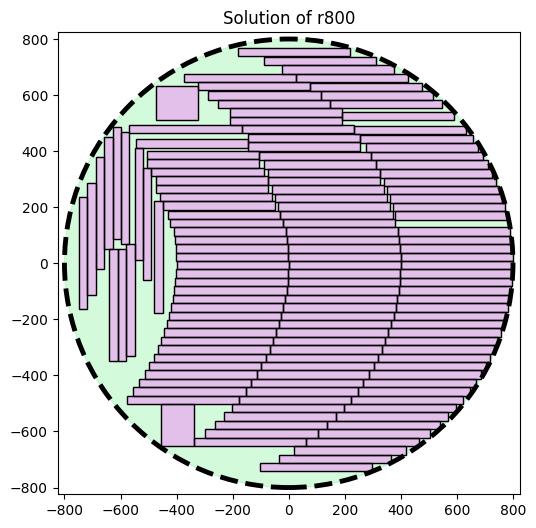

In [14]:
final_simple_solution(800, population_size=20)

Problem size: r850
Score achieved: 586960
Theoretical maximum: 693550
Percentage of theoretical maximum: 84.63%


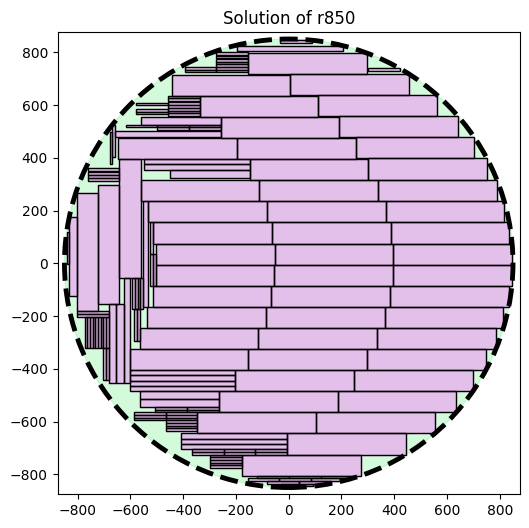

In [15]:
final_simple_solution(850, population_size=20)

Problem size: r1000
Score achieved: 32320
Theoretical maximum: 39270
Percentage of theoretical maximum: 82.30%

Required score: 17500
Percentage of required score: 184.69%


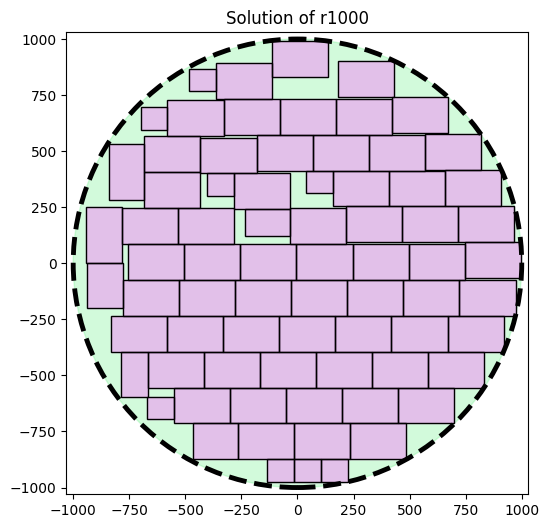

In [16]:
final_simple_solution(1000, population_size=20)

Problem size: r1100
Score achieved: 45000
Theoretical maximum: 57020
Percentage of theoretical maximum: 78.92%

Required score: 25000
Percentage of required score: 180.00%


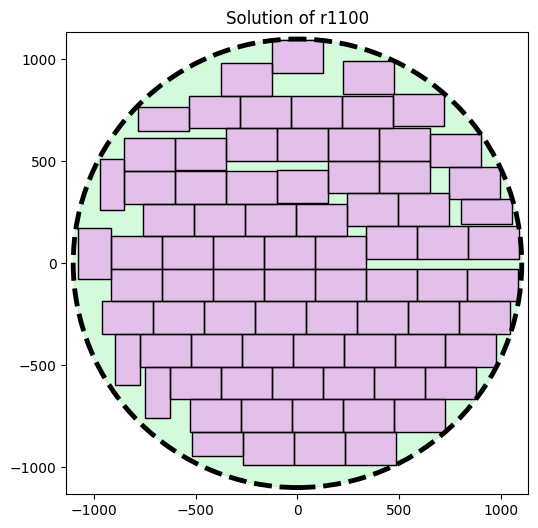

In [17]:
final_simple_solution(1100, population_size=20)

Problem size: r1200
Score achieved: 46780
Theoretical maximum: 56549
Percentage of theoretical maximum: 82.73%

Required score: 30000
Percentage of required score: 155.93%


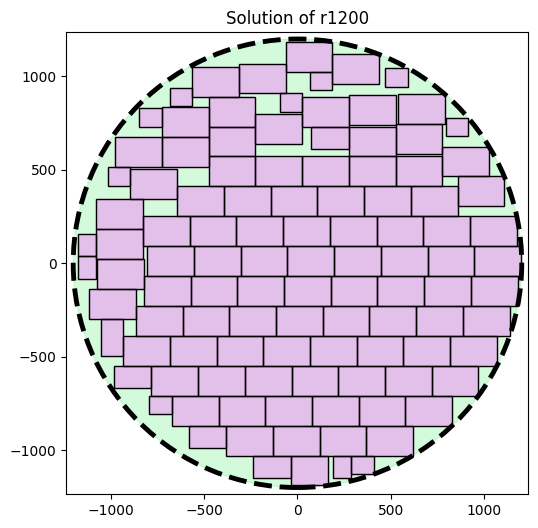

In [18]:
final_simple_solution(1200, population_size=20)